split data in half (stratified) and perform grid-search on one half to determine random-forest parameters

In [22]:
import os, sys, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint
import matplotlib.pyplot as plt
import time

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from config.feature_sets import get_linguistic_features, get_acoustic_features
from data_preparation.stratified_splits import create_and_save_stratified_folds
from regression.evaluation_helpers import load_task_dataframe, get_model_feature_list

# set file paths
demographics_path = os.path.join(GIT_DIRECTORY, "data/demographics_data.csv")
output_path = os.path.join(GIT_DIRECTORY, "data", "stratified_folds_grid_search.csv")
half_split_path = os.path.join(GIT_DIRECTORY, "data", "stratified_folds_grid_search.csv")
scores_path     = os.path.join(GIT_DIRECTORY, "data", "language_scores_all_subjects.csv")

# load data
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)

# parameters
task_name = "picnicScene"
target = "SemanticFluencyScore"
model_name = "full"
test_fold_label = 1  # held-out half
random_state = 42
n_iterations_random = 100 # randomized search iterations
refine_with_grid = True # if true: small grid around randomized-search-winner

# prepare demographics
for col in ["Gender","Education","Country"]:
    demographics[col] = demographics[col].astype("string").str.lower().str.strip()
demographics["Socioeconomic"] = pd.to_numeric(demographics["Socioeconomic"], errors="coerce")

demographics["Gender"] = demographics["Gender"].map({"f": 0, "m": 1})
education_map = {
    "less_than_highschool": 1,
    "high_school": 2,
    "vocational": 3,
    "bachelor": 4,
    "master": 5,
    "phd": 6,
    "no_answer": np.nan
}
demographics["Education"] = demographics["Education"].map(education_map)
demographics["Education_group_code"] = demographics["Education"].map({
    1: 0, # low
    2: 1, 3: 1, # medium
    4: 2, 5: 2, 6: 2 # high
})
demographics["Country"] = demographics["Country"].map({"uk": 0, "usa": 1})
demographics.drop(columns=["Language"], inplace=True, errors="ignore")


In [23]:
# split data in half (stratified)

# generate and save stratified folds
# create_and_save_stratified_folds(demographics_path=demographics_path, output_path=output_path, n_splits=2)

# load half split (n_splits=2)
half_df = pd.read_csv(half_split_path, dtype={"Subject_ID": str}).rename(columns={"fold":"half"})
half_df["Subject_ID"] = half_df["Subject_ID"].astype(str)


In [24]:
# set features
df_task = load_task_dataframe(task_name, target, scores, demographics)
df_task["Subject_ID"] = df_task["Subject_ID"].astype(str)

# merge split info
df = df_task.merge(half_df[["Subject_ID", "strat_group", "half"]], on="Subject_ID", how="inner")

linguistic_features = get_linguistic_features()
acoustic_features = get_acoustic_features()

demographic_cols = ["Age", "Gender", "Education_group_code", "Country", "Socioeconomic"]
model_configs = {
    "baseline": [],
    "demographics": demographic_cols,
    "linguistic": sorted(list(linguistic_features)),
    "acoustic": sorted(list(acoustic_features)),
    "linguistic+acoustic": sorted(list(linguistic_features | acoustic_features)),
    "full": sorted(list(linguistic_features | acoustic_features)) + demographic_cols
}

requested = model_configs[model_name]
feature_cols = get_model_feature_list(df.columns, requested, target)
df_use = df.dropna(subset=[target] + feature_cols).reset_index(drop=True)

picnicScene | full -> train N=493, test N=492, features=50
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=430; total time=   0.8s
[CV] END bootstrap=True, max_depth=29, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=408; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=260; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=660; total time=   2.0s
[CV] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=584; total time=   1.8s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=373; total time=   1.1s
[CV] END bootstrap=False, max_depth=22, max_features=log2, 

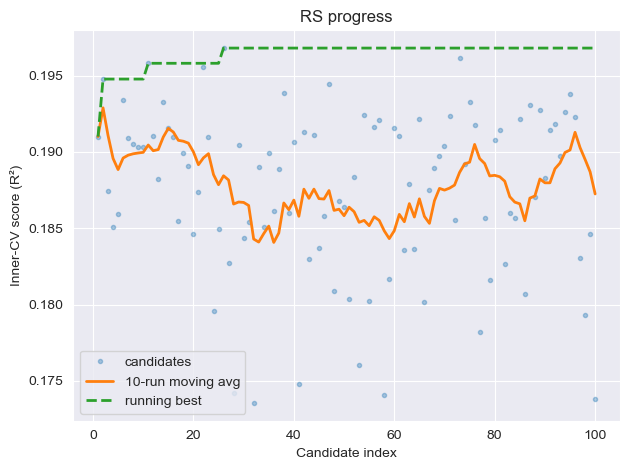

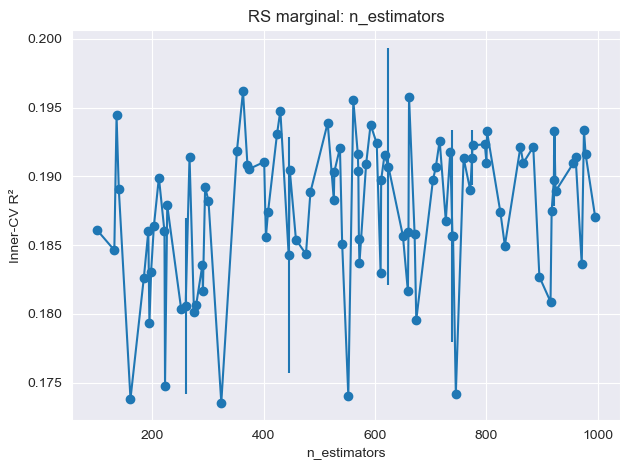

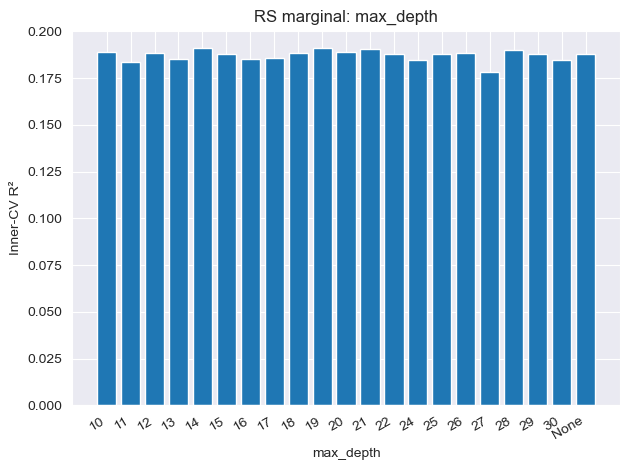

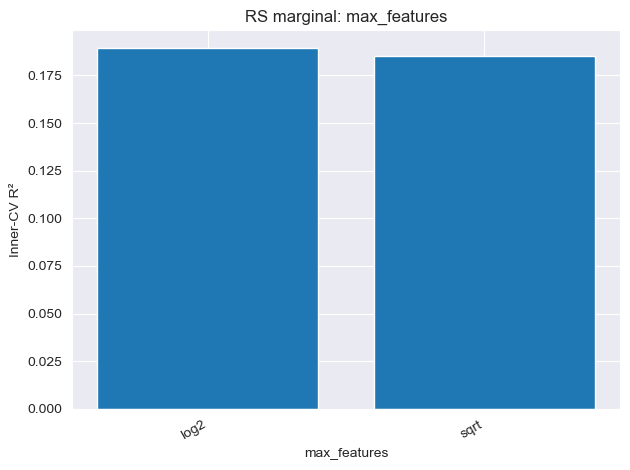

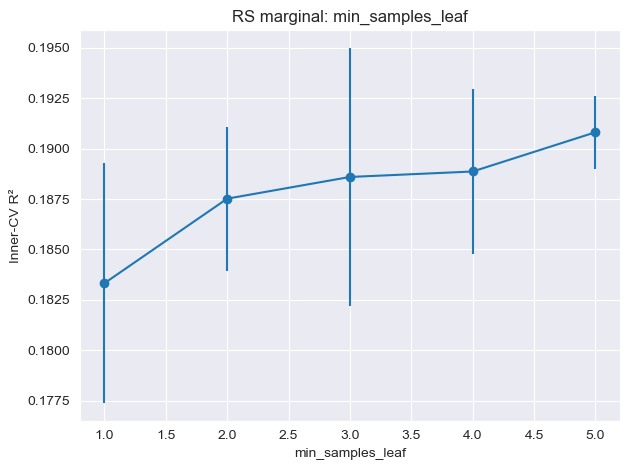

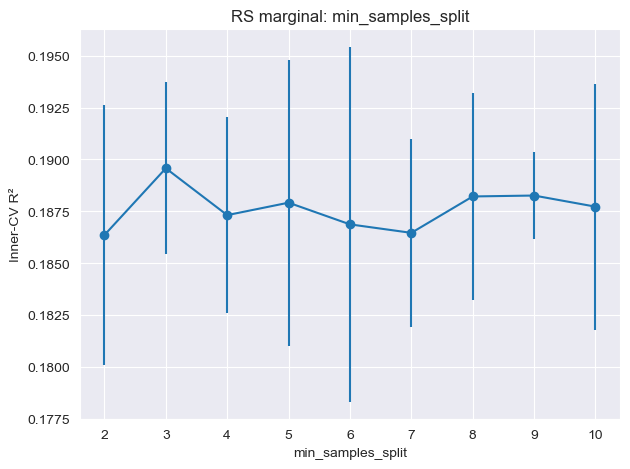

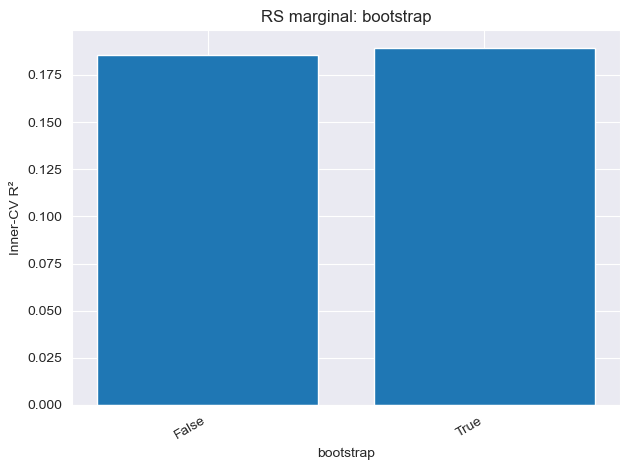

In [27]:
# split data (outer split -> 50% train, 50% test)

train_df = df_use[df_use["half"] != test_fold_label].reset_index(drop=True)
test_df  = df_use[df_use["half"] == test_fold_label].reset_index(drop=True)

X_train = train_df[feature_cols].apply(pd.to_numeric, errors="coerce")
y_train = train_df[target]
X_test  = test_df[feature_cols].apply(pd.to_numeric, errors="coerce")
y_test  = test_df[target]

# drop any remaining NaNs
tr_mask = X_train.notna().all(axis=1) & y_train.notna()
te_mask = X_test.notna().all(axis=1) & y_test.notna()
X_train, y_train = X_train.loc[tr_mask], y_train.loc[tr_mask]
X_test,  y_test  = X_test.loc[te_mask],  y_test.loc[te_mask]

print(f"{task_name} | {model_name} -> train N={len(X_train)}, test N={len(X_test)}, features={len(feature_cols)}")

# cross-validation (inner split -> 5-fold-cv on train-set)
inner_cv = list(KFold(n_splits=5, shuffle=True, random_state=random_state)
                .split(np.arange(len(X_train))))

# randomized search on train-half
# set range of possible parameters
param_dist = {
    "n_estimators": randint(100, 1001),
    "max_depth": [None] + list(range(10, 31)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 6),
    "bootstrap": [True, False]
}

rs = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=random_state, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=n_iterations_random,
    scoring="r2",
    cv=inner_cv,
    n_jobs=-1,
    verbose=2,
    random_state=random_state,
    refit=True,
    return_train_score=True
)
rs.fit(X_train, y_train)
best_params = rs.best_params_
best_cv = float(rs.best_score_)
print("RandomizedSearch best params:", best_params)
print("RandomizedSearch best inner-CV R2:", f"{best_cv:.3f}")

cv_df = pd.DataFrame(rs.cv_results_)  # inner-CV only (train-half)
mean = cv_df["mean_test_score"].values

# progress plot
iters = np.arange(1, len(mean)+1)
cum_best = np.maximum.accumulate(mean)
rolling = pd.Series(mean).rolling(10, min_periods=1).mean()

plt.figure(); plt.plot(iters, mean, ".", alpha=0.35, label="candidates")
plt.plot(iters, rolling, "-", lw=2, label="10-run moving avg")
plt.plot(iters, cum_best, "--", lw=2, label="running best")
plt.xlabel("Candidate index"); plt.ylabel("Inner-CV score (R²)"); plt.title("RS progress"); plt.legend(); plt.tight_layout(); plt.show()

# marginal effects: value -> mean CV score
def marginal_plot(cv_df, param_col, title):
    if param_col not in cv_df:
        return

    s = cv_df[param_col]
    vals = [v for v in s.unique()]

    def is_num(v):
        try:
            # treat bools as categorical
            if isinstance(v, (bool, np.bool_)) or v is None:
                return False
            float(v)
            return True
        except Exception:
            return False

    numeric_ok = len(vals) > 0 and all(is_num(v) for v in vals)

    if numeric_ok:
        # convert to numeric, drop NaNs just in case
        x = pd.to_numeric(s, errors="coerce")
        tmp = pd.DataFrame({"x": x, "score": cv_df["mean_test_score"]}).dropna(subset=["x"])
        g = tmp.groupby("x")["score"].agg(["mean","std","count"]).reset_index().sort_values("x")

        plt.figure()
        plt.errorbar(g["x"], g["mean"], yerr=g["std"], fmt="-o")
        plt.xlabel(param_col.replace("param_","")); plt.ylabel("Inner-CV R²")
        plt.title(title); plt.tight_layout(); plt.show()
    else:
        # categorical: stringify, include None as "None"
        x = s.apply(lambda v: "None" if v is None else str(v))
        tmp = pd.DataFrame({"x": x, "score": cv_df["mean_test_score"]})
        g = tmp.groupby("x", dropna=False)["score"].agg(["mean","std","count"]).reset_index()

        plt.figure()
        plt.bar(g["x"], g["mean"])
        plt.xticks(rotation=30, ha="right")
        plt.ylabel("Inner-CV R²"); plt.xlabel(param_col.replace("param_",""))
        plt.title(title); plt.tight_layout(); plt.show()

for p in ["param_n_estimators","param_max_depth","param_max_features",
          "param_min_samples_leaf","param_min_samples_split","param_bootstrap"]:
    marginal_plot(cv_df, p, f"RS marginal: {p.replace('param_','')}")



In [30]:
# refine with grid-search
if refine_with_grid:
    bp = rs.best_params_

    def win(center, radius, low, high, step=1):
        a = max(low, int(center) - radius)
        b = min(high, int(center) + radius)
        return list(range(a, b + 1, step)) if a <= b else [int(center)]

    n_estimators_step = 50

    grid = {
        "n_estimators":      win(bp["n_estimators"],    radius=200, low=100, high=1000, step=n_estimators_step),
        "max_depth":         win(bp["max_depth"],       radius=3,   low=10,  high=30,   step=1),
        "max_features":     ["sqrt", "log2"],  # fixed choices from RS space
        "min_samples_split": win(bp["min_samples_split"], radius=1,  low=2,   high=10,   step=1),
        "min_samples_leaf":  win(bp["min_samples_leaf"],  radius=1,  low=1,   high=5,    step=1),
        "bootstrap":        [True],
    }

    gs = GridSearchCV(
        estimator=RandomForestRegressor(random_state=random_state, n_jobs=-1),
        param_grid=grid,
        scoring="r2",
        cv=inner_cv,
        n_jobs=-1,
        verbose=2,
        refit=True,
        return_train_score=False
    )
    gs.fit(X_train, y_train)
    best_params = gs.best_params_
    best_cv     = float(gs.best_score_)
    print("GridSearch best params:", best_params)
    print("GridSearch best inner-CV R2:", f"{best_cv:.3f}")


Fitting 5 folds for each of 1134 candidates, totalling 5670 fits
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=424; total time=   1.0s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=524; total time=   1.0s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=574; total time=   1.4s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=674; total time=   1.5s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=774; total time=   1.5s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=824; total time=   1.8s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=474; to

In [31]:
# final fit on full train half, then one test on held-out half
best_rf = RandomForestRegressor(random_state=random_state, n_jobs=-1, **best_params)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

r2  = float(r2_score(y_test, y_pred))
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))

print(f"TEST | R2={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")

TEST | R2=0.162 | RMSE=5.119 | MAE=4.097
